# TransientAsciiMetric

This notebook demonstrates how to use the TransientAsciiMetric, which lets you use an ascii file to specify a lightcurve template, and then either calculate the likelihood of detecting a transient with that lightcurve or generate the actual lightcurve datapoints.

Running this notebook requires sympy to be installed. You can do it in the notebook using the command
~~~
! pip install sympy
~~~

Also, you need to make sure you have done the following before running the notebook:
~~~
cd sims_maf_contrib
eups declare sims_maf_contrib -r . -t $USER
setup sims_maf_contrib -t $USER -t sims
~~~

In [2]:
#    import maf packages
import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import healpy as hp
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots

from mafContrib import TransientAsciiMetric
from statistics import *

First do some bookkeeping: connect to the opsim database and set up the output directory and resultsDb.

In [6]:
# Set the database and query
runName = 'baseline_nexp2_v1.7_10yrs.db'


#This next command assumes you have downloaded baseline2018a.db into the tutorials directory in this repo.
#Change this path according to your datbase and where it is saved.
opsdb = db.OpsimDatabase('/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db')


# Set the output directory
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir)

Set up the transient ascii metric.  

Note that if `dataout` is True, the output at each slicePoint will be a dictionary of: 
 'lcNumber', 'expMJD', 'epoch', 'filter', 'lcMag', 'SNR', 'detected' (a flag indicating whether that lightcurve met the detection criteria). 
If `dataout` is False, the output at each slicePoint will be the likelihood of detecting a transient with this lightcurve.

In [7]:
#We use a real blazar light curve
asciiLC = '1553_maf.dat'


transMetric = TransientAsciiMetric(asciiLC, surveyDuration=1,mjdCol='observationStartMJD', 
                                   detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                                   nPreT=0, preT=0, nFilters=0, filterT=None, nPerLC=0, peakOffset=0,
                                   dataout=True)

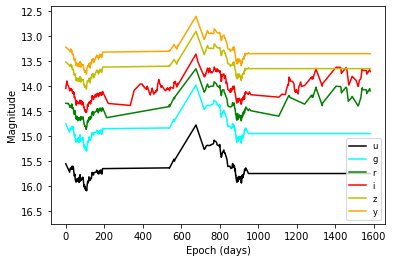

In [8]:
# Use the metric to generate a tightly sampled lightcurve, to illustrate what the lightcurve looks like.
filterNames = ['u', 'g', 'r', 'i', 'z', 'y']

colors = {'u': 'k', 'g': 'cyan', 'r': 'g', 'i': 'r', 'z': 'y', 'y': 'orange'}
times = np.arange(0, transMetric.transDuration, 0.5)
lc = {}
for f in filterNames:
    lc[f] = transMetric.make_lightCurve(times, np.array([f]*len(times)))

plt.figure()
for f in filterNames:
    plt.plot(times, lc[f], color=colors[f], label=f)
plt.ylim(max(lc[f])+3, min(lc[f])-0.2)
plt.xlabel('Epoch (days)')
plt.ylabel('Magnitude')
plt.legend(fontsize='smaller', numpoints=1)

Set up the slicer and sql constraint, assign them all to a metricBundle.

In [9]:
# Slicer - we just want to look at what the full lightcurve output looks like, so choose a few representative points.
# With the UserPointsSlicer, you can set ra/dec for the places you want to evaluate.
# These ra/dec pairs are 1 DD field and 3 WFD fields.
ra = np.array([ 34.39339593,  30.0])
dec = np.array([ -5.09032894,   -30.0])

slicer = slicers.UserPointsSlicer(ra, dec)

# SQL constraint.
# select the of the survey that you want to run 
year = 0
sqlconstraint = 'night between %f and %f '% ((365.25*year,365.25*(year+10)))
lightcurve_metric = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, runName=runName)

In [10]:
# run the metric
bgroup = metricBundles.MetricBundleGroup({0: lightcurve_metric}, opsdb, 
                                         outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint night between 0.000000 and 3652.500000  for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'observationStartMJD', 'filter']
Found 2044648 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plot each of the lightcurves created by setting off a set of back-to-back transients at each of the slicePoints. Note that not every slicePoint is sampled equally in time, especially since we only looked at one year. 

We write the simulated light curves for both the WFD and DDF into files, one for each band: field0 refers to the DDF, while field1 to the WFD

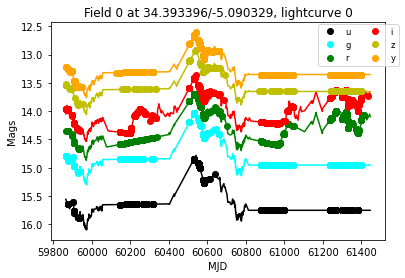

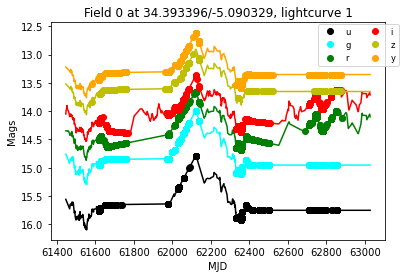

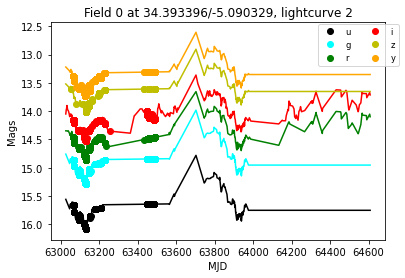

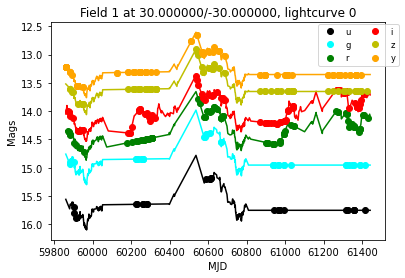

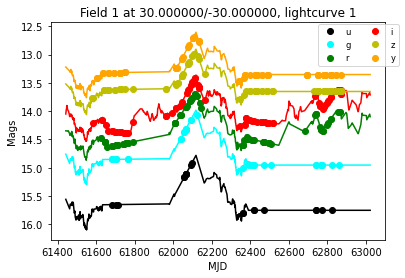

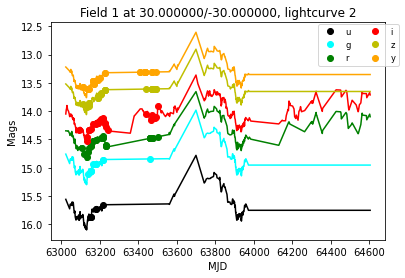

In [11]:
for i, data in enumerate(lightcurve_metric.metricValues):
    filenameu="field"+str(i)+"_u.csv"
    filenameg="field"+str(i)+"_g.csv"
    filenamer="field"+str(i)+"_r.csv"
    filenamei="field"+str(i)+"_i.csv"
    filenamez="field"+str(i)+"_z.csv"
    filenamey="field"+str(i)+"_y.csv"

    fdu = open(filenameu, "a")
    fdg = open(filenameg, "a")
    fdr = open(filenamer, "a")
    fdi = open(filenamei, "a")
    fdz = open(filenamez, "a")
    fdy = open(filenamey, "a")


    fdu.write("Mjd, Mags, Filter \n")    
    fdg.write("Mjd, Mags, Filter \n")
    fdr.write("Mjd, Mags, Filter \n")
    fdi.write("Mjd, Mags, Filter \n")
    fdz.write("Mjd, Mags, Filter \n")
    fdy.write("Mjd, Mags, Filter \n")



    for lcN in np.unique(data['lcNumber']):
        match = np.where(data['lcNumber'] == lcN)
        plt.figure()
        epoch = data['epoch'][match]
        mjd = data['expMJD'][match]
        mags = data['lcMag'][match]
        filters = data['filter'][match]
        
        for f in filterNames:
            filtermatch = np.where(filters == f)
            plt.plot(times - epoch[0] + mjd[0], lc[f], color=colors[f])
            plt.plot(mjd[filtermatch], mags[filtermatch], 'o', color=colors[f], label=f)
            j=0
            while j<len(mjd[filtermatch]):
                if filters[filtermatch][j] =="u":
                    fdu.write("{0}, {1}, {2} \n".format(mjd[filtermatch][j],mags[filtermatch][j],filters[filtermatch][j]))
                elif filters[filtermatch][j] =="g":
                    fdg.write("{0}, {1}, {2} \n".format(mjd[filtermatch][j],mags[filtermatch][j],filters[filtermatch][j]))
                elif filters[filtermatch][j] =="r":
                    fdr.write("{0}, {1}, {2} \n".format(mjd[filtermatch][j],mags[filtermatch][j],filters[filtermatch][j]))
                elif filters[filtermatch][j] =="i":
                    fdi.write("{0}, {1}, {2} \n".format(mjd[filtermatch][j],mags[filtermatch][j],filters[filtermatch][j]))
                elif filters[filtermatch][j] =="z":
                    fdz.write("{0}, {1}, {2} \n".format(mjd[filtermatch][j],mags[filtermatch][j],filters[filtermatch][j]))
                elif filters[filtermatch][j] =="y":
                    fdy.write("{0}, {1}, {2} \n".format(mjd[filtermatch][j],mags[filtermatch][j],filters[filtermatch][j]))
                else :
                    print("filter error")
                j += 1
              

        plt.ylim(plt.ylim()[::-1])
        plt.legend(ncol = 2, loc = (.8,.8), numpoints=1, fontsize='smaller') 
        plt.xlabel('MJD')
        plt.ylabel('Mags')
        plt.title('Field %d at %f/%f, lightcurve %d' % (i, np.degrees(slicer.slicePoints['ra'][i]), 
                                                        np.degrees(slicer.slicePoints['dec'][i]), lcN))
        plt.show()
        
    fdu.close()    
    fdg.close()
    fdr.close()
    fdi.close()
    fdz.close()
    fdy.close()



Print the number of points for each band

In [12]:
f0u=pd.read_csv("field0_u.csv",header=0)
f0g=pd.read_csv("field0_g.csv",header=0)
f0r=pd.read_csv("field0_r.csv",header=0)
f0i=pd.read_csv("field0_i.csv",header=0)
f0z=pd.read_csv("field0_z.csv",header=0)
f0y=pd.read_csv("field0_y.csv",header=0)

f1u=pd.read_csv("field1_u.csv",header=0)
f1g=pd.read_csv("field1_g.csv",header=0)
f1r=pd.read_csv("field1_r.csv",header=0)
f1i=pd.read_csv("field1_i.csv",header=0)
f1z=pd.read_csv("field1_z.csv",header=0)
f1y=pd.read_csv("field1_y.csv",header=0)


print("############FIELD 0##################")
print('Field0_u = ',len(f0u))
print('Field0_g = ',len(f0g))
print('Field0_r = ',len(f0r))
print('Field0_i = ',len(f0i))
print('Field0_z = ',len(f0z))
print('Field0_y = ',len(f0y))

print("############FIELD 1##################")
print('Field1_u = ',len(f1u))
print('Field1_g = ',len(f1g))
print('Field1_r = ',len(f1r))
print('Field1_i = ',len(f1i))
print('Field1_z = ',len(f1z))
print('Field1_y = ',len(f1y))


############FIELD 0##################
Field0_u =  963
Field0_g =  1865
Field0_r =  3740
Field0_i =  3765
Field0_z =  1831
Field0_y =  3699
############FIELD 1##################
Field1_u =  53
Field1_g =  81
Field1_r =  200
Field1_i =  195
Field1_z =  174
Field1_y =  199


Derive colour indices coupling data in a chosen time interval 

In [13]:
def colornumber3 (datafile,file_check,intranight):
	import numpy as np
	import pandas as pd

	df=pd.read_csv(datafile,header=0,delimiter=',').iloc[:,0]
	dfa=np.array(df)
    
	fc = pd.read_csv(file_check,header=0,delimiter=',').iloc[:,0]
	fca = np.array(fc)

	match_number = 0
	match_info = []
	dummy = 0
	i = 0
    
	np.sort(dfa)
	np.sort(fca)
	
	print("Elements in Datafile: " + str(len(dfa)) + "\nElements in CheckFile: " + str(len(fca)) +"\n")
   
	while(i < len(dfa)):

		j = 0
		ex_loop = 0

		while ((j < len(fca)) and (ex_loop == 0)):
			if (abs(float(dfa[i]) - float(fca[j])) <= intranight):
				match_number += 1
				ex_loop = 1
				match_info.append([dfa[i], fca[j]])
				fca = np.delete(fca, j)
			else:
				if ((float(fca[j]) - float(dfa[i])) > intranight):
					ex_loop = 1
			j += 1
		i += 1

	print("Number of matches: " + str(match_number) +"\n")
	
	#return match_number, match_info
	return match_number

Choose the filter pairs to make colour indices (e.g. u and g) and the desired maximum time separation between observations in the two bands in days (e.g. 0.1)

In [14]:
print("#######FIELD0: DDF#####")
print("u and g")
colornumber3("field0_u.csv","field0_g.csv",0.1)
print("u and r")
colornumber3("field0_u.csv","field0_r.csv",0.1)
print("u and i")
colornumber3("field0_u.csv","field0_i.csv",0.1)
print("u and z")
colornumber3("field0_u.csv","field0_z.csv",0.1)
print("u and y")
colornumber3("field0_u.csv","field0_y.csv",0.1)
print("g and r")
colornumber3("field0_g.csv","field0_r.csv",0.1)
print("g and i")
colornumber3("field0_g.csv","field0_i.csv",0.1)
print("g and z")
colornumber3("field0_g.csv","field0_z.csv",0.1)
print("g and y")
colornumber3("field0_g.csv","field0_y.csv",0.1)
print("r and i")
colornumber3("field0_r.csv","field0_i.csv",0.1)
print("r and z")
colornumber3("field0_r.csv","field0_z.csv",0.1)
print("r and y")
colornumber3("field0_r.csv","field0_y.csv",0.1)
print("i and z")
colornumber3("field0_i.csv","field0_z.csv",0.1)
print("i and y")
colornumber3("field0_i.csv","field0_y.csv",0.1)
print("z and y")
colornumber3("field0_z.csv","field0_y.csv",0.1)

#######FIELD0#####
u and g
Elements in Datafile: 963
Elements in CheckFile: 1865

Number of matches: 928

u and r
Elements in Datafile: 963
Elements in CheckFile: 3740

Number of matches: 939

u and i
Elements in Datafile: 963
Elements in CheckFile: 3765

Number of matches: 916

u and z
Elements in Datafile: 963
Elements in CheckFile: 1831

Number of matches: 0

u and y
Elements in Datafile: 963
Elements in CheckFile: 3699

Number of matches: 908

g and r
Elements in Datafile: 1865
Elements in CheckFile: 3740

Number of matches: 1827

g and i
Elements in Datafile: 1865
Elements in CheckFile: 3765

Number of matches: 1803

g and z
Elements in Datafile: 1865
Elements in CheckFile: 1831

Number of matches: 635

g and y
Elements in Datafile: 1865
Elements in CheckFile: 3699

Number of matches: 1777

r and i
Elements in Datafile: 3740
Elements in CheckFile: 3765

Number of matches: 3624

r and z
Elements in Datafile: 3740
Elements in CheckFile: 1831

Number of matches: 1262

r and y
Element

1309

**COLORE WFD**

In [15]:
print("#######FIELD1: WFD#####")
print("u and g")
colornumber3("field1_u.csv","field1_g.csv",0.1)
print("u and r")
colornumber3("field1_u.csv","field1_r.csv",0.1)
print("u and i")
colornumber3("field1_u.csv","field1_i.csv",0.1)
print("u and z")
colornumber3("field1_u.csv","field1_z.csv",0.1)
print("u and y")
colornumber3("field1_u.csv","field1_y.csv",0.1)
print("g and r")
colornumber3("field1_g.csv","field1_r.csv",0.1)
print("g and i")
colornumber3("field1_g.csv","field1_i.csv",0.1)
print("g and z")
colornumber3("field1_g.csv","field1_z.csv",0.1)
print("g and y")
colornumber3("field1_g.csv","field1_y.csv",0.1)
print("r and i")
colornumber3("field1_r.csv","field1_i.csv",0.1)
print("r and z")
colornumber3("field1_r.csv","field1_z.csv",0.1)
print("r and y")
colornumber3("field1_r.csv","field1_y.csv",0.1)
print("i and z")
colornumber3("field1_i.csv","field1_z.csv",0.1)
print("i and y")
colornumber3("field1_i.csv","field1_y.csv",0.1)
print("z and y")
colornumber3("field1_z.csv","field1_y.csv",0.1)

#######FIELD1#####
u and g
Elements in Datafile: 53
Elements in CheckFile: 81

Number of matches: 36

u and r
Elements in Datafile: 53
Elements in CheckFile: 200

Number of matches: 22

u and i
Elements in Datafile: 53
Elements in CheckFile: 195

Number of matches: 2

u and z
Elements in Datafile: 53
Elements in CheckFile: 174

Number of matches: 0

u and y
Elements in Datafile: 53
Elements in CheckFile: 199

Number of matches: 0

g and r
Elements in Datafile: 81
Elements in CheckFile: 200

Number of matches: 48

g and i
Elements in Datafile: 81
Elements in CheckFile: 195

Number of matches: 10

g and z
Elements in Datafile: 81
Elements in CheckFile: 174

Number of matches: 0

g and y
Elements in Datafile: 81
Elements in CheckFile: 199

Number of matches: 0

r and i
Elements in Datafile: 200
Elements in CheckFile: 195

Number of matches: 60

r and z
Elements in Datafile: 200
Elements in CheckFile: 174

Number of matches: 4

r and y
Elements in Datafile: 200
Elements in CheckFile: 199



53

Calculate the minimum time distance between observations in two filters to get the corresponding colour index

In [16]:
def minimun_mjd_colornumber (datafile,file_check, file_result):
	import numpy as np
	import pandas as pd

	df=pd.read_csv(datafile,header=0,delimiter=',').iloc[:,0]
	dfa=np.array(df)
    
	fc = pd.read_csv(file_check,header=0,delimiter=',').iloc[:,0]
	fca = np.array(fc)	
	
	np.sort(dfa)
	np.sort(fca)
	
	print("Elements in Datafile: " + str(len(dfa)) + "\nElements in CheckFile: " + str(len(fca)) +"\n")
  
	#Open the result file
	fd_r = open(file_result, "w")
	fd_r.write("Mjd_Source, Mjd_Matched, Min_diff\n") 

	i = 0

	while(i < len(dfa)):
		j = 0
		pos = 0
		diff = 0
		exit = 0
		while ((j < len(fca)) and (exit == 0)):
			#First element must be stored as temporary difference
			if (j == 0):
				diff = abs(float(dfa[i]) - float(fca[j]))
				pos = 0
			else:
				#Update minimum in case computed value is minor than the previous one
				if (abs(float(dfa[i]) - float(fca[j])) < diff):
					diff = abs(float(dfa[i]) - float(fca[j]))
					pos = j

				#Before check j index in order to avoid an out of bound exception and that values to be checked are positive
				#In case the value of next element of file check is greater than zero
				#and difference is greater than the current computer exit from while cycle 
				if (((j+1) < len(fca)) and (float(fca[j]) > 0)):
					if ((float(fca[j+1]) > float(fca[j]) and (abs(float(dfa[i]) - float(fca[j])) > diff))):
						exit = 1
			j += 1

		#Update the result file  
		fd_r.write("{0}, {1}, {2}\n".format(dfa[i], fca[pos], diff))
		i += 1

	#Close the result file    
	fd_r.close()



This is done for all filter pairs and the results are written into files

In [17]:
###################WFD###############
print("#######FIELD1: WFD#####")
print("u and g")
minimun_mjd_colornumber("field1_u.csv","field1_g.csv","WFD_baselineug.csv")

print("#######FIELD1#####")
print("u and i")
minimun_mjd_colornumber("field1_u.csv","field1_i.csv","WFD_baselineui.csv")


print("#######FIELD1#####")
print("u and r")
minimun_mjd_colornumber("field1_u.csv","field1_r.csv","WFD_baselineur.csv")

print("#######FIELD1#####")
print("u and y")
minimun_mjd_colornumber("field1_u.csv","field1_y.csv","WFD_baselineuy.csv")

print("#######FIELD1#####")
print("u and z")
minimun_mjd_colornumber("field1_u.csv","field1_z.csv","WFD_baselineuz.csv")

print("#######FIELD1#####")
print("g and r")
minimun_mjd_colornumber("field1_g.csv","field1_r.csv","WFD_baselinegr.csv")

print("#######FIELD1#####")
print("g and i")
minimun_mjd_colornumber("field1_g.csv","field1_i.csv","WFD_baselinegi.csv")

print("#######FIELD1#####")
print("g and y")
minimun_mjd_colornumber("field1_g.csv","field1_y.csv","WFD_baselinegy.csv")

print("#######FIELD1#####")
print("u and z")
minimun_mjd_colornumber("field1_g.csv","field1_z.csv","WFD_baselinegz.csv")

print("#######FIELD1#####")
print("r and i")
minimun_mjd_colornumber("field1_r.csv","field1_i.csv","WFD_baselineri.csv")

print("#######FIELD1#####")
print("r and y")
minimun_mjd_colornumber("field1_r.csv","field1_y.csv","WFD_baselinery.csv")

print("#######FIELD1#####")
print("r and z")
minimun_mjd_colornumber("field1_r.csv","field1_z.csv","WFD_baselinerz.csv")

print("#######FIELD1#####")
print("i and y")
minimun_mjd_colornumber("field1_i.csv","field1_y.csv","WFD_baselineiy.csv")

print("#######FIELD1#####")
print("i and z")
minimun_mjd_colornumber("field1_i.csv","field1_z.csv","WFD_baselineiz.csv")


print("#######FIELD1#####")
print("z and y")
minimun_mjd_colornumber("field1_z.csv","field1_y.csv","WFD_baselinezy.csv")



#######FIELD1#####
u and g
Elements in Datafile: 53
Elements in CheckFile: 81

#######FIELD1#####
u and i
Elements in Datafile: 53
Elements in CheckFile: 195

#######FIELD1#####
u and r
Elements in Datafile: 53
Elements in CheckFile: 200

#######FIELD1#####
u and y
Elements in Datafile: 53
Elements in CheckFile: 199

#######FIELD1#####
u and z
Elements in Datafile: 53
Elements in CheckFile: 174

#######FIELD1#####
g and r
Elements in Datafile: 81
Elements in CheckFile: 200

#######FIELD1#####
g and i
Elements in Datafile: 81
Elements in CheckFile: 195

#######FIELD1#####
g and y
Elements in Datafile: 81
Elements in CheckFile: 199

#######FIELD1#####
u and z
Elements in Datafile: 81
Elements in CheckFile: 174

#######FIELD1#####
r and i
Elements in Datafile: 200
Elements in CheckFile: 195

#######FIELD1#####
r and y
Elements in Datafile: 200
Elements in CheckFile: 199

#######FIELD1#####
r and z
Elements in Datafile: 200
Elements in CheckFile: 174

#######FIELD1#####
i and y
Elements in

In [18]:
###################DDF###############
print("#######FIELD0: DDF#####")
print("u and g")
minimun_mjd_colornumber("field0_u.csv","field0_g.csv","DDF_baselineug.csv")

print("#######field0#####")
print("u and i")
minimun_mjd_colornumber("field0_u.csv","field0_i.csv","DDF_baselineui.csv")


print("#######field0#####")
print("u and r")
minimun_mjd_colornumber("field0_u.csv","field0_r.csv","DDF_baselineur.csv")

print("#######field0#####")
print("u and y")
minimun_mjd_colornumber("field0_u.csv","field0_y.csv","DDF_baselineuy.csv")

print("#######field0#####")
print("u and z")
minimun_mjd_colornumber("field0_u.csv","field0_z.csv","DDF_baselineuz.csv")

print("#######field0#####")
print("g and r")
minimun_mjd_colornumber("field0_g.csv","field0_r.csv","DDF_baselinegr.csv")

print("#######field0#####")
print("g and i")
minimun_mjd_colornumber("field0_g.csv","field0_i.csv","DDF_baselinegi.csv")

print("#######field0#####")
print("g and y")
minimun_mjd_colornumber("field0_g.csv","field0_y.csv","DDF_baselinegy.csv")

print("#######field0#####")
print("u and z")
minimun_mjd_colornumber("field0_g.csv","field0_z.csv","DDF_baselinegz.csv")

print("#######field0#####")
print("r and i")
minimun_mjd_colornumber("field0_r.csv","field0_i.csv","DDF_baselineri.csv")

print("#######field0#####")
print("r and y")
minimun_mjd_colornumber("field0_r.csv","field0_y.csv","DDF_baselinery.csv")

print("#######field0#####")
print("r and z")
minimun_mjd_colornumber("field0_r.csv","field0_z.csv","DDF_baselinerz.csv")

print("#######field0#####")
print("i and y")
minimun_mjd_colornumber("field0_i.csv","field0_y.csv","DDF_baselineiy.csv")

print("#######field0#####")
print("i and z")
minimun_mjd_colornumber("field0_i.csv","field0_z.csv","DDF_baselineiz.csv")


print("#######field0#####")
print("z and y")
minimun_mjd_colornumber("field0_z.csv","field0_y.csv","DDF_baselinezy.csv")

#######field0#####
u and g
Elements in Datafile: 963
Elements in CheckFile: 1865

#######field0#####
u and i
Elements in Datafile: 963
Elements in CheckFile: 3765

#######field0#####
u and r
Elements in Datafile: 963
Elements in CheckFile: 3740

#######field0#####
u and y
Elements in Datafile: 963
Elements in CheckFile: 3699

#######field0#####
u and z
Elements in Datafile: 963
Elements in CheckFile: 1831

#######field0#####
g and r
Elements in Datafile: 1865
Elements in CheckFile: 3740

#######field0#####
g and i
Elements in Datafile: 1865
Elements in CheckFile: 3765

#######field0#####
g and y
Elements in Datafile: 1865
Elements in CheckFile: 3699

#######field0#####
u and z
Elements in Datafile: 1865
Elements in CheckFile: 1831

#######field0#####
r and i
Elements in Datafile: 3740
Elements in CheckFile: 3765

#######field0#####
r and y
Elements in Datafile: 3740
Elements in CheckFile: 3699

#######field0#####
r and z
Elements in Datafile: 3740
Elements in CheckFile: 1831

#######fi

Read the files created above and makes a plot for the WFD and another for the DDF

In [19]:
WFD_ug=pd.read_csv("WFD_baselineug.csv",header=0)
WFD_mjd_sourceug=WFD_ug.iloc[:,0]
WFD_mjd_matchedug=WFD_ug.iloc[:,1]
WFD_min_diffug=WFD_ug.iloc[:,2]

WFD_ur=pd.read_csv("WFD_baselineur.csv",header=0)
WFD_mjd_sourceur=WFD_ur.iloc[:,0]
WFD_mjd_matchedur=WFD_ur.iloc[:,1]
WFD_min_diffur=WFD_ur.iloc[:,2]

WFD_ui=pd.read_csv("WFD_baselineui.csv",header=0)
WFD_mjd_souiceui=WFD_ui.iloc[:,0]
WFD_mjd_matchedui=WFD_ui.iloc[:,1]
WFD_min_diffui=WFD_ui.iloc[:,2]

WFD_uz=pd.read_csv("WFD_baselineuz.csv",header=0)
WFD_mjd_souzceuz=WFD_uz.iloc[:,0]
WFD_mjd_matcheduz=WFD_uz.iloc[:,1]
WFD_min_diffuz=WFD_uz.iloc[:,2]

WFD_uy=pd.read_csv("WFD_baselineuy.csv",header=0)
WFD_mjd_souyceuy=WFD_uy.iloc[:,0]
WFD_mjd_matcheduy=WFD_uy.iloc[:,1]
WFD_min_diffuy=WFD_uy.iloc[:,2]

WFD_gr=pd.read_csv("WFD_baselinegr.csv",header=0)
WFD_mjd_sogrcegr=WFD_gr.iloc[:,0]
WFD_mjd_matchedgr=WFD_gr.iloc[:,1]
WFD_min_diffgr=WFD_gr.iloc[:,2]

WFD_gi=pd.read_csv("WFD_baselinegi.csv",header=0)
WFD_mjd_sogicegi=WFD_gi.iloc[:,0]
WFD_mjd_matchedgi=WFD_gi.iloc[:,1]
WFD_min_diffgi=WFD_gi.iloc[:,2]

WFD_gz=pd.read_csv("WFD_baselinegz.csv",header=0)
WFD_mjd_sogzcegz=WFD_gz.iloc[:,0]
WFD_mjd_matchedgz=WFD_gz.iloc[:,1]
WFD_min_diffgz=WFD_gz.iloc[:,2]

WFD_gy=pd.read_csv("WFD_baselinegy.csv",header=0)
WFD_mjd_sogycegy=WFD_gy.iloc[:,0]
WFD_mjd_matchedgy=WFD_gy.iloc[:,1]
WFD_min_diffgy=WFD_gy.iloc[:,2]

WFD_ri=pd.read_csv("WFD_baselineri.csv",header=0)
WFD_mjd_soriceri=WFD_ri.iloc[:,0]
WFD_mjd_matchedri=WFD_ri.iloc[:,1]
WFD_min_diffri=WFD_ri.iloc[:,2]

WFD_rz=pd.read_csv("WFD_baselinerz.csv",header=0)
WFD_mjd_sorzcerz=WFD_rz.iloc[:,0]
WFD_mjd_matchedrz=WFD_rz.iloc[:,1]
WFD_min_diffrz=WFD_rz.iloc[:,2]

WFD_ry=pd.read_csv("WFD_baselinery.csv",header=0)
WFD_mjd_sorycery=WFD_ry.iloc[:,0]
WFD_mjd_matchedry=WFD_ry.iloc[:,1]
WFD_min_diffry=WFD_ry.iloc[:,2]

WFD_iz=pd.read_csv("WFD_baselineiz.csv",header=0)
WFD_mjd_soizceiz=WFD_iz.iloc[:,0]
WFD_mjd_matchediz=WFD_iz.iloc[:,1]
WFD_min_diffiz=WFD_iz.iloc[:,2]

WFD_iy=pd.read_csv("WFD_baselineiy.csv",header=0)
WFD_mjd_soiyceiy=WFD_iy.iloc[:,0]
WFD_mjd_matchediy=WFD_iy.iloc[:,1]
WFD_min_diffiy=WFD_iy.iloc[:,2]

WFD_zy=pd.read_csv("WFD_baselinezy.csv",header=0)
WFD_mjd_sozycezy=WFD_zy.iloc[:,0]
WFD_mjd_matchedzy=WFD_zy.iloc[:,1]
WFD_min_diffzy=WFD_zy.iloc[:,2]




In [20]:
DDF_ug=pd.read_csv("DDF_baselineug.csv",header=0)
DDF_mjd_sourceug=DDF_ug.iloc[:,0]
DDF_mjd_matchedug=DDF_ug.iloc[:,1]
DDF_min_diffug=DDF_ug.iloc[:,2]

DDF_ur=pd.read_csv("DDF_baselineur.csv",header=0)
DDF_mjd_sourceur=DDF_ur.iloc[:,0]
DDF_mjd_matchedur=DDF_ur.iloc[:,1]
DDF_min_diffur=DDF_ur.iloc[:,2]

DDF_ui=pd.read_csv("DDF_baselineui.csv",header=0)
DDF_mjd_souiceui=DDF_ui.iloc[:,0]
DDF_mjd_matchedui=DDF_ui.iloc[:,1]
DDF_min_diffui=DDF_ui.iloc[:,2]

DDF_uz=pd.read_csv("DDF_baselineuz.csv",header=0)
DDF_mjd_souzceuz=DDF_uz.iloc[:,0]
DDF_mjd_matcheduz=DDF_uz.iloc[:,1]
DDF_min_diffuz=DDF_uz.iloc[:,2]

DDF_uy=pd.read_csv("DDF_baselineuy.csv",header=0)
DDF_mjd_souyceuy=DDF_uy.iloc[:,0]
DDF_mjd_matcheduy=DDF_uy.iloc[:,1]
DDF_min_diffuy=DDF_uy.iloc[:,2]

DDF_gr=pd.read_csv("DDF_baselinegr.csv",header=0)
DDF_mjd_sogrcegr=DDF_gr.iloc[:,0]
DDF_mjd_matchedgr=DDF_gr.iloc[:,1]
DDF_min_diffgr=DDF_gr.iloc[:,2]

DDF_gi=pd.read_csv("DDF_baselinegi.csv",header=0)
DDF_mjd_sogicegi=DDF_gi.iloc[:,0]
DDF_mjd_matchedgi=DDF_gi.iloc[:,1]
DDF_min_diffgi=DDF_gi.iloc[:,2]

DDF_gz=pd.read_csv("DDF_baselinegz.csv",header=0)
DDF_mjd_sogzcegz=DDF_gz.iloc[:,0]
DDF_mjd_matchedgz=DDF_gz.iloc[:,1]
DDF_min_diffgz=DDF_gz.iloc[:,2]

DDF_gy=pd.read_csv("DDF_baselinegy.csv",header=0)
DDF_mjd_sogycegy=DDF_gy.iloc[:,0]
DDF_mjd_matchedgy=DDF_gy.iloc[:,1]
DDF_min_diffgy=DDF_gy.iloc[:,2]

DDF_ri=pd.read_csv("DDF_baselineri.csv",header=0)
DDF_mjd_soriceri=DDF_ri.iloc[:,0]
DDF_mjd_matchedri=DDF_ri.iloc[:,1]
DDF_min_diffri=DDF_ri.iloc[:,2]

DDF_rz=pd.read_csv("DDF_baselinerz.csv",header=0)
DDF_mjd_sorzcerz=DDF_rz.iloc[:,0]
DDF_mjd_matchedrz=DDF_rz.iloc[:,1]
DDF_min_diffrz=DDF_rz.iloc[:,2]

DDF_ry=pd.read_csv("DDF_baselinery.csv",header=0)
DDF_mjd_sorycery=DDF_ry.iloc[:,0]
DDF_mjd_matchedry=DDF_ry.iloc[:,1]
DDF_min_diffry=DDF_ry.iloc[:,2]

DDF_iz=pd.read_csv("DDF_baselineiz.csv",header=0)
DDF_mjd_soizceiz=DDF_iz.iloc[:,0]
DDF_mjd_matchediz=DDF_iz.iloc[:,1]
DDF_min_diffiz=DDF_iz.iloc[:,2]

DDF_iy=pd.read_csv("DDF_baselineiy.csv",header=0)
DDF_mjd_soiyceiy=DDF_iy.iloc[:,0]
DDF_mjd_matchediy=DDF_iy.iloc[:,1]
DDF_min_diffiy=DDF_iy.iloc[:,2]

DDF_zy=pd.read_csv("DDF_baselinezy.csv",header=0)
DDF_mjd_sozycezy=DDF_zy.iloc[:,0]
DDF_mjd_matchedzy=DDF_zy.iloc[:,1]
DDF_min_diffzy=DDF_zy.iloc[:,2]

174
174


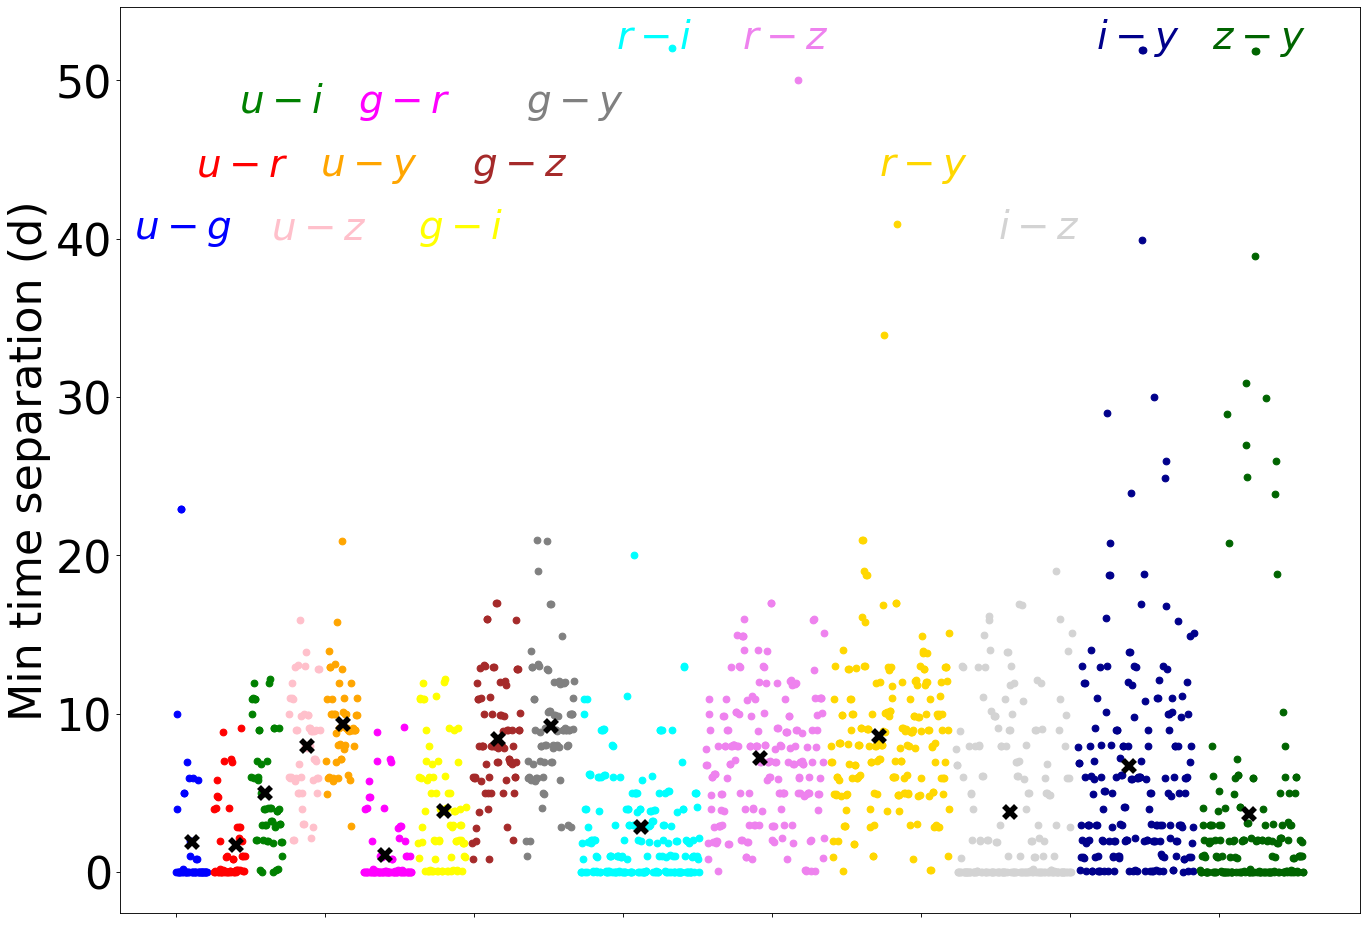

<Figure size 432x288 with 0 Axes>

In [21]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
plt.axes()
#plt.figure(figsize=(15,10))
nug=len(WFD_min_diffug)
ug=np.arange(0,nug,1)



nur=len(WFD_min_diffur)
ur=np.arange(nug+10,nug+10+nur,1)



nui=len(WFD_min_diffui)
ui=np.arange(nug+nur+20,nug+20+nur+nui,1)



nuz=len(WFD_min_diffuz)
uz=np.arange(nug+nur+nui+30,nug+30+nur+nui+nuz,1)



nuy=len(WFD_min_diffuy)
uy=np.arange(nug+nur+nui+nuz+40,nug+40+nur+nui+nuz+nuy,1)



ngr=len(WFD_min_diffgr)
gr=np.arange(nug+nur+nui+nuz+50+nuy,nug+50+nur+nui+nuz+nuy+ngr,1)



ngi=len(WFD_min_diffgi)
gi=np.arange(nug+nur+nui+nuz+60+nuy+ngr,nug+60+nur+nui+nuz+nuy+ngr+ngi,1)

ngz=len(WFD_min_diffgz)
gz=np.arange(nug+nur+nui+nuz+70+nuy+ngr+ngi,nug+70+nur+nui+nuz+nuy+ngr+ngi+ngz,1)

ngy=len(WFD_min_diffgy)
gy=np.arange(nug+nur+nui+nuz+80+nuy+ngr+ngi+ngz,nug+80+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy,1)


nri=len(WFD_min_diffri)
ri=np.arange(nug+nur+nui+nuz+90+nuy+ngr+ngi+ngz+ngy,nug+90+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri,1)

nrz=len(WFD_min_diffrz)
rz=np.arange(nug+nur+nui+nuz+100+nuy+ngr+ngi+ngz+ngy+nri,nug+100+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz,1)

nry=len(WFD_min_diffry)
ry=np.arange(nug+nur+nui+nuz+110+nuy+ngr+ngi+ngz+ngy+nri+nrz,nug+110+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry,1)

niz=len(WFD_min_diffiz)
iz=np.arange(nug+nur+nui+nuz+120+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry,nug+120+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz,1)

niy=len(WFD_min_diffiy)
iy=np.arange(nug+nur+nui+nuz+130+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz,nug+130+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz+niy,1)

nzy=len(WFD_min_diffzy)
zy=np.arange(nug+nur+nui+nuz+140+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz+niy,nug+140+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz+niy+nzy,1)
print(nzy)
print(len(zy))

plt.text(-70, 40, '$\it{u-g}$',color='blue',fontsize=35)
plt.text(nug-20, 44, '$\it{u-r}$',color='red',fontsize=35)
plt.text(nug+nur, 48, '$\it{u-i}$',color='green',fontsize=35)
plt.text(nug+nur+nui, 40, '$\it{u-z}$',color='pink',fontsize=35)
plt.text(nug+nur+nui+nuz+30, 44, '$\it{u-y}$',color='orange',fontsize=35)
plt.text(nug+nur+nui+nuz+nuy+40, 48, '$\it{g-r}$',color='magenta',fontsize=35)
plt.text(nug+60+nur+nui+nuz+nuy+ngr, 40, '$\it{g-i}$',color='yellow',fontsize=35)
plt.text(nug+70+nur+nui+nuz+nuy+ngr+ngi, 44, '$\it{g-z}$',color='brown',fontsize=35)
plt.text(nug+80+nur+nui+nuz+nuy+ngr+ngi+ngz, 48, '$\it{g-y}$',color='grey',fontsize=35)
plt.text(nug+150+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy, 52, '$\it{r-i}$',color='cyan',fontsize=35)
plt.text(nug+160+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri, 52, '$\it{r-z}$',color='violet',fontsize=35)
plt.text(nug+190+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz, 44, '$\it{r-y}$',color='gold',fontsize=35)
plt.text(nug+190+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry, 40, '$\it{i-z}$',color='lightgray',fontsize=35)
plt.text(nug+160+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz, 52, '$\it{i-y}$',color='darkblue',fontsize=35)
plt.text(nug+160+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz+niy, 52, '$\it{z-y}$',color='darkgreen',fontsize=35)


WFD_xx=[27,100,150,220,280,350,450,540,630,780,980,1180,1400,1600,1800]
WFD_yy=[mean(WFD_min_diffug),mean(WFD_min_diffur),mean(WFD_min_diffui),mean(WFD_min_diffuz),mean(WFD_min_diffuy),mean(WFD_min_diffgr),mean(WFD_min_diffgi),mean(WFD_min_diffgz),mean(WFD_min_diffgy),mean(WFD_min_diffri),mean(WFD_min_diffrz),mean(WFD_min_diffry),mean(WFD_min_diffiz),mean(WFD_min_diffiy),mean(WFD_min_diffzy)]




plt.plot(ug,WFD_min_diffug,'o',color='blue')
plt.plot(27,mean(WFD_min_diffug),marker='x',ms=10,mew=5,color='black')

plt.plot(ur,WFD_min_diffur,'o',color='red')
plt.plot(100,mean(WFD_min_diffur),marker='x',ms=10,mew=5,color='black')

plt.plot(ui,WFD_min_diffui,'o',color='green')
plt.plot(150,mean(WFD_min_diffui),marker='x',ms=10,mew=5,color='black')

plt.plot(uz,WFD_min_diffuz,'o',color='pink')
plt.plot(220,mean(WFD_min_diffuz),marker='x',ms=10,mew=5,color='black')

plt.plot(uy,WFD_min_diffuy,'o',color='orange')
plt.plot(280,mean(WFD_min_diffuy),marker='x',ms=10,mew=5,color='black')

plt.plot(gr,WFD_min_diffgr,'o',color='magenta')
plt.plot(350,mean(WFD_min_diffgr),marker='x',ms=10,mew=5,color='black')

plt.plot(gi,WFD_min_diffgi,'o',color='yellow')
plt.plot(450,mean(WFD_min_diffgi),marker='x',ms=10,mew=5,color='black')

plt.plot(gz,WFD_min_diffgz,'o',color='brown')
plt.plot(540,mean(WFD_min_diffgz),marker='x',ms=10,mew=5,color='black')

plt.plot(gy,WFD_min_diffgy,'o',color='grey')
plt.plot(630,mean(WFD_min_diffgy),marker='x',ms=10,mew=5,color='black')

plt.plot(ri,WFD_min_diffri,'o',color='cyan')
plt.plot(780,mean(WFD_min_diffri),marker='x',ms=10,mew=5,color='black')

plt.plot(rz,WFD_min_diffrz,'o',color='violet')
plt.plot(980,mean(WFD_min_diffrz),marker='x',ms=10,mew=5,color='black')

plt.plot(ry,WFD_min_diffry,'o',color='gold')
plt.plot(1180,mean(WFD_min_diffry),marker='x',ms=10,mew=5,color='black')

plt.plot(iz,WFD_min_diffiz,'o',color='lightgray')
plt.plot(1400,mean(WFD_min_diffiz),marker='x',ms=10,mew=5,color='black')

plt.plot(iy,WFD_min_diffiy,'o',color='darkblue')
plt.plot(1600,mean(WFD_min_diffiy),marker='x',ms=10,mew=5,color='black')

plt.plot(zy,WFD_min_diffzy,'o',color='darkgreen')
plt.plot(1800,mean(WFD_min_diffzy),marker='x',ms=10,mew=5,color='black')

#plt.plot(WFD_xx,WFD_yy,'-.',color='grey')
plt.xticks(color='w')
plt.yticks(fontsize=40)
plt.ylabel('Min time separation (d)',fontsize=40)



plt.savefig("WFD_Min_time_separation3.png")


plt.show()
plt.clf()


1831
1831


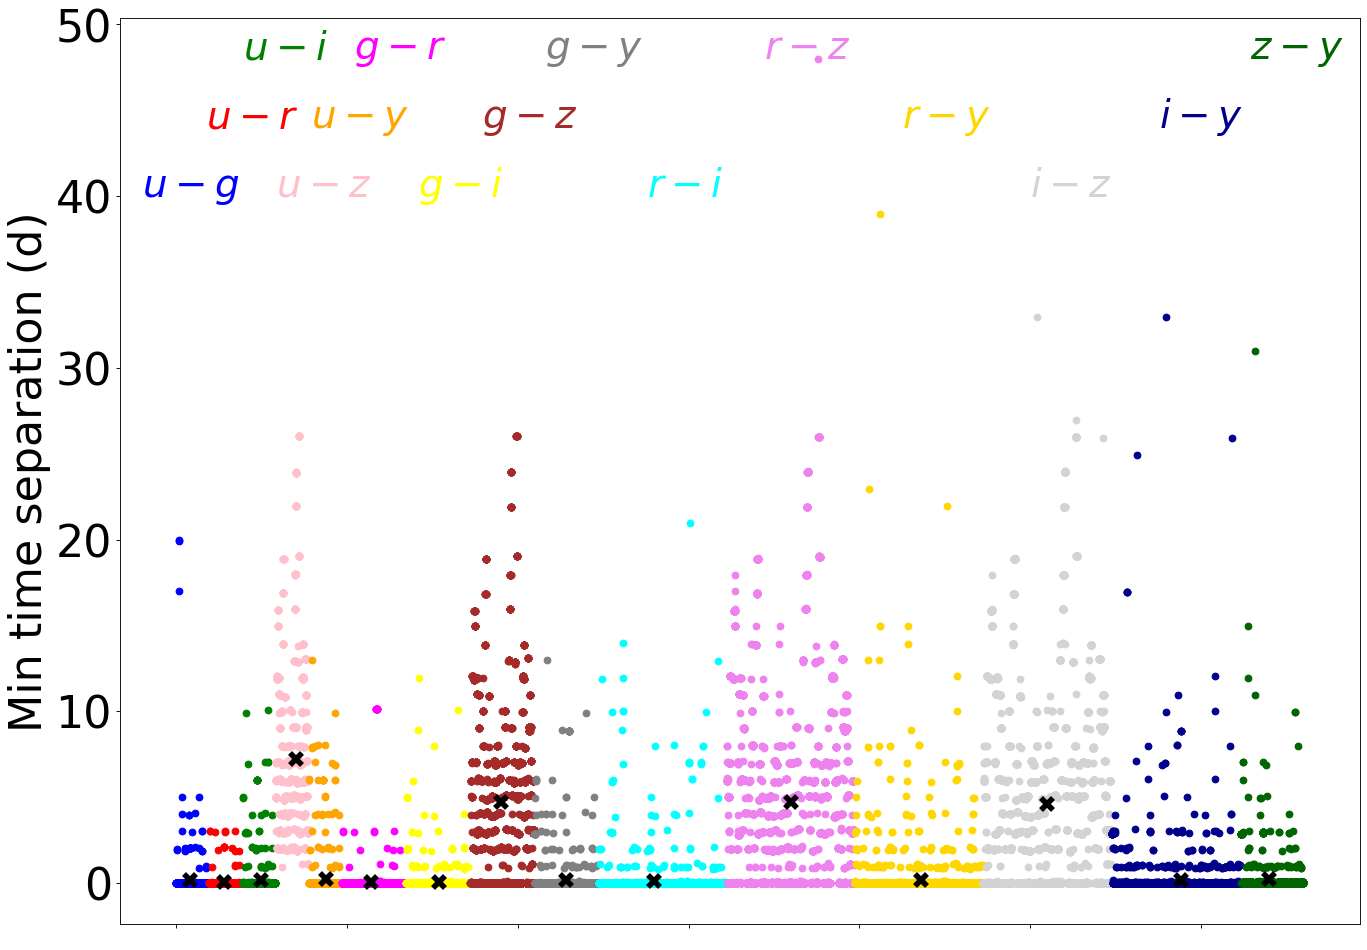

<Figure size 432x288 with 0 Axes>

In [22]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
plt.axes()
#plt.figure(figsize=(15,10))
nug=len(DDF_min_diffug)
ug=np.arange(0,nug,1)



nur=len(DDF_min_diffur)
ur=np.arange(nug+10,nug+10+nur,1)



nui=len(DDF_min_diffui)
ui=np.arange(nug+nur+20,nug+20+nur+nui,1)



nuz=len(DDF_min_diffuz)
uz=np.arange(nug+nur+nui+30,nug+30+nur+nui+nuz,1)



nuy=len(DDF_min_diffuy)
uy=np.arange(nug+nur+nui+nuz+40,nug+40+nur+nui+nuz+nuy,1)



ngr=len(DDF_min_diffgr)
gr=np.arange(nug+nur+nui+nuz+50+nuy,nug+50+nur+nui+nuz+nuy+ngr,1)



ngi=len(DDF_min_diffgi)
gi=np.arange(nug+nur+nui+nuz+60+nuy+ngr,nug+60+nur+nui+nuz+nuy+ngr+ngi,1)

ngz=len(DDF_min_diffgz)
gz=np.arange(nug+nur+nui+nuz+70+nuy+ngr+ngi,nug+70+nur+nui+nuz+nuy+ngr+ngi+ngz,1)

ngy=len(DDF_min_diffgy)
gy=np.arange(nug+nur+nui+nuz+80+nuy+ngr+ngi+ngz,nug+80+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy,1)


nri=len(DDF_min_diffri)
ri=np.arange(nug+nur+nui+nuz+90+nuy+ngr+ngi+ngz+ngy,nug+90+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri,1)

nrz=len(DDF_min_diffrz)
rz=np.arange(nug+nur+nui+nuz+100+nuy+ngr+ngi+ngz+ngy+nri,nug+100+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz,1)

nry=len(DDF_min_diffry)
ry=np.arange(nug+nur+nui+nuz+110+nuy+ngr+ngi+ngz+ngy+nri+nrz,nug+110+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry,1)

niz=len(DDF_min_diffiz)
iz=np.arange(nug+nur+nui+nuz+120+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry,nug+120+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz,1)

niy=len(DDF_min_diffiy)
iy=np.arange(nug+nur+nui+nuz+130+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz,nug+130+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz+niy,1)

nzy=len(DDF_min_diffzy)
zy=np.arange(nug+nur+nui+nuz+140+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz+niy,nug+140+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz+niy+nzy,1)
print(nzy)
print(len(zy))

plt.text(-1000, 40, '$\it{u-g}$',color='blue',fontsize=35)
plt.text(nug-100, 44, '$\it{u-r}$',color='red',fontsize=35)
plt.text(nug+20+nur, 48, '$\it{u-i}$',color='green',fontsize=35)
plt.text(nug+30+nur+nui, 40, '$\it{u-z}$',color='pink',fontsize=35)
plt.text(nug+100+nur+nui+nuz, 44, '$\it{u-y}$',color='orange',fontsize=35)
plt.text(nug+400+nur+nui+nuz+nuy, 48, '$\it{g-r}$',color='magenta',fontsize=35)
plt.text(nug+400+nur+nui+nuz+nuy+ngr, 40, '$\it{g-i}$',color='yellow',fontsize=35)
plt.text(nug+400+nur+nui+nuz+nuy+ngr+ngi, 44, '$\it{g-z}$',color='brown',fontsize=35)
plt.text(nug+400+nur+nui+nuz+nuy+ngr+ngi+ngz, 48, '$\it{g-y}$',color='grey',fontsize=35)
plt.text(nug+1500+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy, 40, '$\it{r-i}$',color='cyan',fontsize=35)
plt.text(nug+1200+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri, 48, '$\it{r-z}$',color='violet',fontsize=35)
plt.text(nug+1500+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz, 44, '$\it{r-y}$',color='gold',fontsize=35)
plt.text(nug+1500+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry, 40, '$\it{i-z}$',color='lightgray',fontsize=35)
plt.text(nug+1500+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz, 44, '$\it{i-y}$',color='darkblue',fontsize=35)
plt.text(nug+400+nur+nui+nuz+nuy+ngr+ngi+ngz+ngy+nri+nrz+nry+niz+niy, 48, '$\it{z-y}$',color='darkgreen',fontsize=35)


DDF_xx=[27,100,150,220,280,350,450,540,630,780,980,1180,1400,1600,1800]
DDF_yy=[mean(DDF_min_diffug),mean(DDF_min_diffur),mean(DDF_min_diffui),mean(DDF_min_diffuz),mean(DDF_min_diffuy),mean(DDF_min_diffgr),mean(DDF_min_diffgi),mean(DDF_min_diffgz),mean(DDF_min_diffgy),mean(DDF_min_diffri),mean(DDF_min_diffrz),mean(DDF_min_diffry),mean(DDF_min_diffiz),mean(DDF_min_diffiy),mean(DDF_min_diffzy)]




plt.plot(ug,DDF_min_diffug,'o',color='blue')
plt.plot(400,mean(DDF_min_diffug),marker='x',ms=10,mew=5,color='black')

plt.plot(ur,DDF_min_diffur,'o',color='red')
plt.plot(1400,mean(DDF_min_diffur),marker='x',ms=10,mew=5,color='black')

plt.plot(ui,DDF_min_diffui,'o',color='green')
plt.plot(2500,mean(DDF_min_diffui),marker='x',ms=10,mew=5,color='black')

plt.plot(uz,DDF_min_diffuz,'o',color='pink')
plt.plot(3500,mean(DDF_min_diffuz),marker='x',ms=10,mew=5,color='black')

plt.plot(uy,DDF_min_diffuy,'o',color='orange')
plt.plot(4400,mean(DDF_min_diffuy),marker='x',ms=10,mew=5,color='black')

plt.plot(gr,DDF_min_diffgr,'o',color='magenta')
plt.plot(5700,mean(DDF_min_diffgr),marker='x',ms=10,mew=5,color='black')

plt.plot(gi,DDF_min_diffgi,'o',color='yellow')
plt.plot(7700,mean(DDF_min_diffgi),marker='x',ms=10,mew=5,color='black')

plt.plot(gz,DDF_min_diffgz,'o',color='brown')
plt.plot(9500,mean(DDF_min_diffgz),marker='x',ms=10,mew=5,color='black')

plt.plot(gy,DDF_min_diffgy,'o',color='grey')
plt.plot(11400,mean(DDF_min_diffgy),marker='x',ms=10,mew=5,color='black')

plt.plot(ri,DDF_min_diffri,'o',color='cyan')
plt.plot(14000,mean(DDF_min_diffri),marker='x',ms=10,mew=5,color='black')

plt.plot(rz,DDF_min_diffrz,'o',color='violet')
plt.plot(18000,mean(DDF_min_diffrz),marker='x',ms=10,mew=5,color='black')

plt.plot(ry,DDF_min_diffry,'o',color='gold')
plt.plot(21800,mean(DDF_min_diffry),marker='x',ms=10,mew=5,color='black')

plt.plot(iz,DDF_min_diffiz,'o',color='lightgray')
plt.plot(25500,mean(DDF_min_diffiz),marker='x',ms=10,mew=5,color='black')

plt.plot(iy,DDF_min_diffiy,'o',color='darkblue')
plt.plot(29400,mean(DDF_min_diffiy),marker='x',ms=10,mew=5,color='black')

plt.plot(zy,DDF_min_diffzy,'o',color='darkgreen')
plt.plot(32000,mean(DDF_min_diffzy),marker='x',ms=10,mew=5,color='black')

#plt.plot(DDF_xx,DDF_yy,'-.',color='grey')
plt.xticks(color='w')
plt.yticks(fontsize=40)
plt.ylabel('Min time separation (d)',fontsize=40)



plt.savefig("DDF_Min_time_separation3.png")


plt.show()
plt.clf()




The following part belongs to the original code and was not used.
Now let's look at the metric, with dataout = False. In this case, it calculates the likelihood of detecting a transient at each slicePoint. We can also add some additional detection criteria.

In [44]:
metric = TransientAsciiMetric(asciiLC, surveyDuration=1,mjdCol='observationStartMJD',
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                              nPreT=3, preT=5, nFilters=3, filterT=30, nPerLC=2, peakOffset=0,
                              dataout=False)
slicer = slicers.HealpixSlicer(nside=16)
year = 0
sqlconstraint = 'night between %d and %d' % (365.25 * year, 365.25 * (year + 10))

plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
plotDict = {'colorMin': 0, 'colorMax': 1}

summaryMetrics = [metrics.MeanMetric(), metrics.RmsMetric()]

bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                    runName=runName, summaryMetrics=summaryMetrics,
                                    plotDict=plotDict, plotFuncs=plotFuncs)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [45]:
bundlegroup = metricBundles.MetricBundleGroup({0: bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bundlegroup.runAll()

Querying database SummaryAllProps with constraint night between 0 and 3652 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 2231536 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "night between 0 and 3652" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


Plotting complete.


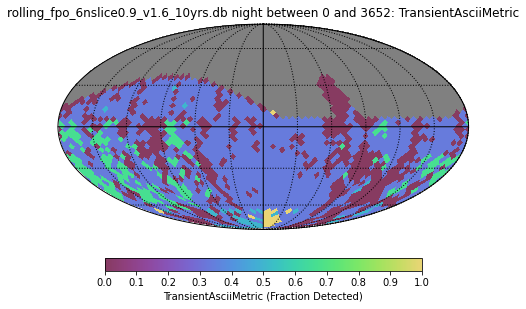

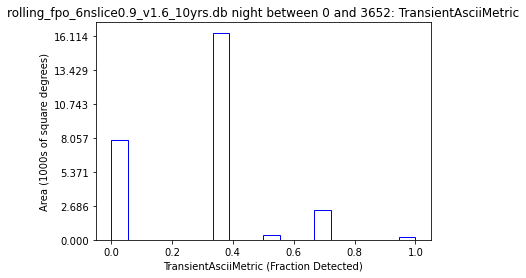

In [46]:
bundlegroup.plotAll(closefigs=False)

In [47]:
print (bundle.summaryValues)

{'Mean': 0.27354002624671914, 'Rms': 0.2047080933237992}
